In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model, to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from hashlib import md5

In [2]:
def df_shrink(df, obj2cat=False, int2uint=False):
    # Giảm bộ nhớ cho DataFrame
    
    df_copy = df.copy()
    
    # Xử lý các cột integer
    for col in df_copy.select_dtypes(include=['int64']).columns:
        if int2uint:
            # Chuyển sang unsigned integer nếu được bật
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='unsigned')
        else:
            # Chuyển sang integer nhỏ hơn
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='integer')
    
    # Xử lý các cột float
    for col in df_copy.select_dtypes(include=['float64']).columns:
        df_copy[col] = pd.to_numeric(df_copy[col], downcast='float')
    
    # Chuyển đổi các cột object sang category nếu được bật
    if obj2cat:
        for col in df_copy.select_dtypes(include=['object']).columns:
            df_copy[col] = df_copy[col].astype('category')
    
    return df_copy

In [3]:
# Function to create a hash for each column
def hash_column(series):
    return md5(pd.util.hash_pandas_object(series, index=False).values).hexdigest()

# Function to find columns with identical hashes
def find_identical_columns_by_hash(df):
    hash_dict = {}
    for col in df.columns:
        col_hash = hash_column(df[col])
        if col_hash in hash_dict:
            hash_dict[col_hash].append(col)
        else:
            hash_dict[col_hash] = [col]

    return [cols for cols in hash_dict.values() if len(cols) > 1]


In [4]:
# Tải và tiền xử lý dữ liệu
def load_and_preprocess_data():
    # Đọc dữ liệu
    print("Loading data...")
    df = pd.read_csv("/kaggle/input/iot-attack/processed_IIoT.csv")
    df.info()

    # Phân tích dữ liệu ban đầu
    print("\nInitial data analysis:")
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    print(df['Attack_type'].value_counts())

    # Xử lý dữ liệu 

    # Applying the hash function to the DataFrame
    identical_column_groups = find_identical_columns_by_hash(df)
    print("Groups of identical columns:", identical_column_groups)
    
    # Iterate through the list of groups and drop all 
    for group in identical_column_groups:
        df = df.drop(group, axis=1)
        
    df = df_shrink(df, obj2cat=False, int2uint=False)
    print("Data info after shrinking memory:")
    df.info()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)   
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df)

    # Chuyển đổi các cột không phải số thành số bằng Label Encoding
    for column in df.select_dtypes(include=['object']).columns:
      df[column] = df[column].astype(str)
      le = LabelEncoder()
      df[column] = le.fit_transform(df[column])
    
    # Tách features và target
    X = df.drop(['Attack_type'], axis=1)
    y = df['Attack_type']

    print(f"Features after removal: {X.shape[1]}")
    
    # One-hot encoding cho target
    y = to_categorical(y)
    print("Shape of one-hot encoded y:", y.shape)

    return X, y

In [5]:
# Tiền xử lý dữ liệu
X, y = load_and_preprocess_data()

# Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Chuẩn hóa các đặc trưng
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape cho CNN (thêm channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# In thông tin về shape của data
print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
    
# Kiểm tra phân phối classes trong từng tập
print("\nClass distribution in splits:")
print("Training set:", np.sum(y_train, axis=0))
print("Validation set:", np.sum(y_val, axis=0))
print("Test set:", np.sum(y_test, axis=0))

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921663 entries, 0 to 1921662
Data columns (total 96 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   arp.opcode                                                                                            float64
 1   arp.hw.size                                                                                           float64
 2   icmp.checksum                                                                                         float64
 3   icmp.seq_le                                                                                           float64
 4   icmp.unused                                                                                           float64
 5   http.content_length                                          

In [6]:
# Định nghĩa kích thước đầu vào và số lớp đầu ra
input_shape = (X_train.shape[1], 1)
output_classes = 15

In [7]:
# Hàm tạo mô hình CNN 1D
def create_1d_cnn_model(params):
    model = Sequential()

    current_filters = params['num_filters']
    for i in range(params['num_conv_layers']):
        if i == 0:
            # Lớp đầu tiên cần chỉ định input_shape
            model.add(Conv1D(filters=current_filters, 
                           kernel_size=params['kernel_size'], 
                           activation='relu',
                           padding='same',
                           input_shape=(input_shape)))
        else:
            # Các lớp tiếp theo
            model.add(Conv1D(filters=current_filters, 
                           kernel_size=params['kernel_size'], 
                           activation='relu',
                           padding='same'))
        model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))
        current_filters *= 2  # Tăng số filters gấp đôi sau mỗi lớp
    
    model.add(Flatten())

    current_neurons = params['num_neurons_in_dense_layers']
    for _ in range(params['num_dense_layers']):
        model.add(Dense(current_neurons, activation='relu'))
        model.add(Dropout(params['dropout_rate']))
        current_neurons = current_neurons // 2 # Giảm số neurons hai lần sau mỗi lớp

    model.add(Dense(output_classes, activation='softmax'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    loss_function = 'categorical_crossentropy'
    model.compile(loss=loss_function, optimizer=optimizer,
                 metrics=['accuracy', 
                         Precision(name='precision'), 
                         Recall(name='recall'),
                         F1Score(name='f1')])

    return model

In [8]:
# Thông số PSO
n_particles = 5
c1 = 2
c2 = 2
bounds = [
    (1, 3),      # num_conv_layers 
    (0, 2),      # num_filters
    (0, 2),      # kernel_size
    (2, 5),      # pooling_size
    (1, 3),      # num_dense_layers 
    (0, 2),      # num_neurons_in_dense_layers
    (0.1, 0.5),  # dropout_rate
    (1e-5, 1e-2),# learning_rate
    (0, 4),      # batch_size
    (20, 50),    # num_epochs
    (5, 10)      # early-stopping_patience
]
particles = [np.random.uniform(low=bounds[i][0], high=bounds[i][1], size=n_particles) for i in range(len(bounds))]
velocities = [np.zeros(n_particles) for _ in range(len(bounds))]

In [9]:
# Chuyển vị trí thành tham số
def position_to_params(particles, i):
    params_keys = ['num_conv_layers',
               'num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs', 
               'patience']
    params = {}
    for j, key in enumerate(params_keys):
        value = particles[j][i]
        if key in ['num_conv_layers','num_filters', 'kernel_size', 'pooling_size', 
                   'num_dense_layers', 'num_neurons_in_dense_layers', 
                   'batch_size', 'num_epochs', 'patience']:  
            value = int(round(value))
        if key == 'num_filters':
            value_choices = [16, 32, 64]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'num_neurons_in_dense_layers':
            value_choices = [128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'batch_size':
            value_choices = [32, 64, 128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'kernel_size':
            value_choices = [3, 5, 7]
            value = value_choices[min(int(value), len(value_choices)-1)]
        params[key] = value
    return params

In [10]:
# Khởi tạo vị trí tốt nhất cá nhân và vị trí tốt nhất toàn cục
pbest_positions = [position_to_params(particles, i) for i in range(n_particles)]
pbest_fitnesses = [0] * n_particles
gbest_position = None
gbest_fitness = None

In [11]:
# Định nghĩa callback tùy chỉnh để theo dõi thời gian huấn luyện
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []  # Lưu thời gian của từng epoch
        self.total_time = 0.0  # Tổng thời gian huấn luyện

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Ghi lại thời gian bắt đầu của epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian của epoch
        self.epoch_times.append(epoch_time)  # Lưu thời gian của epoch
        self.total_time += epoch_time  # Cộng dồn vào tổng thời gian
        print(f"\nThời gian huấn luyện cho epoch {epoch+1}: {epoch_time:.2f} giây")

    def on_train_end(self, logs=None):
        print(f"\nTổng thời gian huấn luyện cho vòng lặp: {self.total_time:.2f} giây")

In [12]:
# Hàm đánh giá độ thích nghi
def evaluate_fitness(params, particle_id=None, iteration=None):
    
    print(f"{'='*50}")
    if particle_id is not None and iteration is not None:
        print(f"Vòng lặp {iteration+1}, Cá thể {particle_id+1}")
    print("Tham số:")
    for key, value in params.items():
        print(f"{key}: {value}")
        
    model = create_1d_cnn_model(params)
    model.summary()

    # Tạo callback Early Stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',      # Theo dõi validation accuracy
        patience=params['patience'], # Số epoch chờ đợi trước khi dừng
        mode='max',                  # Vì monitor là accuracy nên mode='max'
        restore_best_weights=True,   # Khôi phục trọng số tốt nhất
        verbose=1                    # In thông báo khi dừng
    )

    # Tạo callback để theo dõi thời gian huấn luyện
    timing_callback = TimingCallback()
    
    history = model.fit(X_train, y_train, 
                        batch_size=params['batch_size'], 
                        epochs=params['num_epochs'], 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, timing_callback], 
                        shuffle=True)
    
    # Lấy lịch sử huấn luyện
    metrics_history = history.history

    # In danh sách các giá trị val_accuracy qua các epoch
    print("Danh sách các giá trị val_accuracy qua các epoch:")
    print(metrics_history['val_accuracy'])
    
    # Tìm epoch tốt nhất
    best_epoch = np.argmax(metrics_history['val_accuracy']) 
    
    # Lấy giá trị val_accuracy tại epoch tốt nhất
    val_acc_value = metrics_history['val_accuracy'][best_epoch]
    print(f"Giá trị val accuracy tại epoch tốt nhất (epoch {best_epoch+1}): {val_acc_value}")
    
    # Xử lý trường hợp value là tensor hoặc numpy array
    if isinstance(val_acc_value, tf.Tensor):
        val_acc_value = val_acc_value.numpy()
    if isinstance(val_acc_value, np.ndarray):
        if val_acc_value.size > 1:
            # Nếu mảng có nhiều hơn 1 phần tử, lấy phần tử có giá trị cao nhất 
            val_acc_value = np.max(val_acc_value)
        else:
            val_acc_value = val_acc_value.item()
    
    # Fitness: sử dụng giá trị val_accuracy tốt nhất
    fitness = float(val_acc_value)
    print(f"Fitness (val_acc): {fitness:.4f}")

    # Lưu mô hình sau khi huấn luyện và đánh giá xong
    model_save_path = f"model_iter_{iteration+1}_part_{particle_id+1}.h5"
    print("Đang lưu mô hình sau khi huấn luyện xong...")
    model.save(model_save_path)
    print(f"Mô hình đã được lưu thành công tại: {model_save_path}")
    
    return {
        'model': model,
        'fitness': fitness,
        'history': metrics_history,
        'total_time': timing_callback.total_time
    }

In [13]:
best_model = None
best_model_path = 'best_1d-cnn-pso_model.h5'
best_model_history = None

# Bắt đầu đo thời gian
start_time = time.time()

# Tối ưu hóa PSO
params_keys = ['num_conv_layers',
               'num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs', 
               'patience']

print("=== Khởi tạo quần thể ===")
print("=== Bắt đầu quá trình tối ưu hóa PSO ===")

# Khởi tạo biến theo dõi điều kiện dừng
previous_gbest_fitness = None
no_improvement_count = 0
iteration = 0
    
while True:
    print(f"\nVòng lặp {iteration + 1}")
    
    for i in range(n_particles):
        params = position_to_params(particles, i)
        result = evaluate_fitness(params, i, iteration)
        fitness = result['fitness']

        if fitness > pbest_fitnesses[i]:
            pbest_fitnesses[i] = fitness
            pbest_positions[i] = params.copy()
            print(f"Cập nhật pbest cho cá thể {i+1}: {fitness:.4f}")

        if gbest_fitness is None or fitness > gbest_fitness:
            gbest_fitness = fitness
            gbest_position = params.copy()
            best_model = result['model']
            best_model.save(best_model_path, overwrite=True)
            best_model_history = result['history']
            print(f"Cập nhật gbest: {fitness:.4f}")
            
    print(f"Kết quả sau vòng lặp tối ưu {iteration + 1}:")

    # Kiểm tra điều kiện dừng
    if previous_gbest_fitness is not None:
        improvement = gbest_fitness - previous_gbest_fitness
        if improvement > 0:
            if improvement <= 1e-4:
                no_improvement_count += 1
                print(f"Độ cải thiện không đáng kể (nhỏ hơn ngưỡng 1e-4)")
            else:
                no_improvement_count = 0
                print(f"Best fitness global: {gbest_fitness:.4f}")
                print("Best parameters global:")
                for key, value in gbest_position.items():
                    print(f"{key}: {value}")
                print(f"Độ cải thiện so với vòng lặp trước: {improvement:.4f}")
        else:
            print("Không có sự cải thiện so với vòng lặp trước")
            no_improvement_count += 1
        
        if no_improvement_count >= 3:
            print("\n=== Đã đạt điều kiện dừng - Kết thúc tối ưu hóa ===")
            break
    else:
        print(f"Best fitness global: {gbest_fitness:.4f}")
        print("Best parameters global:")
        for key, value in gbest_position.items():
            print(f"{key}: {value}")
    
    previous_gbest_fitness = gbest_fitness
    
    for i in range(n_particles):
        for j, key in enumerate(params_keys):
            r1, r2 = np.random.random(), np.random.random()
            velocities[j][i] = 0.5 * velocities[j][i] + c1 * r1 * (pbest_positions[i][key] - particles[j][i]) + c2 * r2 * (gbest_position[key] - particles[j][i])
            particles[j][i] += velocities[j][i]
            particles[j][i] = np.clip(particles[j][i], bounds[j][0], bounds[j][1])

    iteration += 1

# Kết thúc đo thời gian
end_time = time.time()

# Tính và in ra thời gian thực thi
execution_time = end_time - start_time
print(f"\nThời gian thực thi tổng thể: {execution_time:.2f} giây")

=== Khởi tạo quần thể ===
=== Bắt đầu quá trình tối ưu hóa PSO ===

Vòng lặp 1
Vòng lặp 1, Cá thể 1
Tham số:
num_conv_layers: 2
num_filters: 64
kernel_size: 3
pooling_size: 3
num_dense_layers: 2
num_neurons_in_dense_layers: 128
dropout_rate: 0.37797636823827174
learning_rate: 0.0036282726261518683
batch_size: 512
num_epochs: 22
patience: 9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 86, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 29, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,159 (774.06 KB)

 Trainable params: 198,159 (774.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9110 - f1: 0.5602 - loss: 0.2359 - precision: 0.9606 - recall: 0.8735
Thời gian huấn luyện cho epoch 1: 25.25 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9110 - f1: 0.5602 - loss: 0.2359 - precision: 0.9606 - recall: 0.8735 - val_accuracy: 0.9336 - val_f1: 0.6413 - val_loss: 0.1471 - val_precision: 0.9685 - val_recall: 0.9067
Epoch 2/22
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9308 - f1: 0.6414 - loss: 0.1501 - precision: 0.9681 - recall: 0.9030
Thời gian huấn luyện cho epoch 2: 14.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9308 - f1: 0.6414 - loss: 0.1500 - precision: 0.9681 - recall: 0.9030 - val_accuracy: 0.9377 - val_f1: 0.6851 - val_loss: 0.1314 - val_precision: 0.9795 - val_recall: 0.9030
Epoch 3/22
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9342 - f1: 0.6779 - loss: 0.1408 - precision: 0.9719 - recall: 0.9067
Thời gian huấn luyện cho epoch 3

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 86, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 43, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 43, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         360,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,895 (1.41 MB)

 Trainable params: 370,895 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/42
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9278 - f1: 0.6567 - loss: 0.1705 - precision: 0.9624 - recall: 0.9025
Thời gian huấn luyện cho epoch 1: 39.75 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9278 - f1: 0.6567 - loss: 0.1705 - precision: 0.9624 - recall: 0.9025 - val_accuracy: 0.9382 - val_f1: 0.7032 - val_loss: 0.1290 - val_precision: 0.9789 - val_recall: 0.9053
Epoch 2/42
10500/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9357 - f1: 0.7034 - loss: 0.1489 - precision: 0.9702 - recall: 0.9113
Thời gian huấn luyện cho epoch 2: 32.10 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9358 - f1: 0.7034 - loss: 0.1489 - precision: 0.9702 - recall: 0.9114 - val_accuracy: 0.9377 - val_f1: 0.7062 - val_loss: 0.1349 - val_precision: 0.9729 - val_recall: 0.9147
Epoch 3/42
10504/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - f1: 0.7114 - loss: 0.1460 - precision: 0.9715 - recall: 0.9118
Thời gian huấn luyện c

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 86, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,119 (746.56 KB)

 Trainable params: 191,119 (746.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/43
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9238 - f1: 0.6160 - loss: 0.1890 - precision: 0.9609 - recall: 0.8960
Thời gian huấn luyện cho epoch 1: 75.67 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9238 - f1: 0.6160 - loss: 0.1890 - precision: 0.9609 - recall: 0.8960 - val_accuracy: 0.9355 - val_f1: 0.6842 - val_loss: 0.1373 - val_precision: 0.9726 - val_recall: 0.9111
Epoch 2/43
21015/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9275 - f1: 0.6422 - loss: 0.1819 - precision: 0.9663 - recall: 0.9009
Thời gian huấn luyện cho epoch 2: 65.68 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.9274 - f1: 0.6422 - loss: 0.1820 - precision: 0.9663 - recall: 0.9009 - val_accuracy: 0.9251 - val_f1: 0.5932 - val_loss: 0.2910 - val_precision: 0.9669 - val_recall: 0.9004
Epoch 3/43
21016/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9207 - f1: 0.5963 - loss: 0.2631 - precision: 0.9634 - recall: 0.8941
Thời gian huấn luyện c

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 86, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 22, 64)              │          14,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,935 (1.44 MB)

 Trainable params: 377,935 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9069 - f1: 0.5250 - loss: 0.2532 - precision: 0.9551 - recall: 0.8751
Thời gian huấn luyện cho epoch 1: 78.24 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9069 - f1: 0.5250 - loss: 0.2532 - precision: 0.9551 - recall: 0.8751 - val_accuracy: 0.8605 - val_f1: 0.3335 - val_loss: 0.3753 - val_precision: 0.9804 - val_recall: 0.8331
Epoch 2/50
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - f1: 0.3247 - loss: 0.5022 - precision: 0.9633 - recall: 0.7965
Thời gian huấn luyện cho epoch 2: 66.27 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.8416 - f1: 0.3247 - loss: 0.5022 - precision: 0.9633 - recall: 0.7965 - val_accuracy: 0.7998 - val_f1: 0.1619 - val_loss: 0.5990 - val_precision: 0.9245 - val_recall: 0.7111
Epoch 3/50
21002/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7963 - f1: 0.1953 - loss: 0.6583 - precision: 0.9176 - recall: 0.7254
Thời gian huấn luyện c

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 86, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 29, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 10, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 449,423 (1.71 MB)

 Trainable params: 449,423 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/31
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9237 - f1: 0.6308 - loss: 0.1887 - precision: 0.9622 - recall: 0.8924
Thời gian huấn luyện cho epoch 1: 31.20 giây
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9237 - f1: 0.6308 - loss: 0.1887 - precision: 0.9622 - recall: 0.8924 - val_accuracy: 0.9399 - val_f1: 0.7263 - val_loss: 0.1245 - val_precision: 0.9759 - val_recall: 0.9127
Epoch 2/31
5242/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9415 - f1: 0.7470 - loss: 0.1222 - precision: 0.9776 - recall: 0.9150
Thời gian huấn luyện cho epoch 2: 20.46 giây
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9415 - f1: 0.7470 - loss: 0.1222 - precision: 0.9776 - recall: 0.9150 - val_accuracy: 0.9471 - val_f1: 0.7789 - val_loss: 0.1070 - val_precision: 0.9831 - val_recall: 0.9212
Epoch 3/31
5251/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9464 - f1: 0.7880 - loss: 0.1142 - precision: 0.9814 - recall: 0.9211
Thời gian huấn luyện cho epoch 3

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 978,575 (3.73 MB)

 Trainable params: 978,575 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9136 - f1: 0.5950 - loss: 0.2405 - precision: 0.9611 - recall: 0.8728
Thời gian huấn luyện cho epoch 1: 39.57 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9136 - f1: 0.5950 - loss: 0.2405 - precision: 0.9611 - recall: 0.8728 - val_accuracy: 0.9326 - val_f1: 0.6267 - val_loss: 0.1394 - val_precision: 0.9774 - val_recall: 0.8985
Epoch 2/35
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9366 - f1: 0.6963 - loss: 0.1339 - precision: 0.9734 - recall: 0.9097
Thời gian huấn luyện cho epoch 2: 23.54 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9366 - f1: 0.6963 - loss: 0.1339 - precision: 0.9734 - recall: 0.9097 - val_accuracy: 0.9402 - val_f1: 0.7063 - val_loss: 0.1218 - val_precision: 0.9761 - val_recall: 0.9147
Epoch 3/35
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9407 - f1: 0.7334 - loss: 0.1263 - precision: 0.9759 - recall: 0.9145
Thời gian huấn luyện cho epoch

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 43, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 22, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 11, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,442,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,737,615 (6.63 MB)

 Trainable params: 1,737,615 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8459 - f1: 0.4007 - loss: 0.7734 - precision: 0.8994 - recall: 0.6408
Thời gian huấn luyện cho epoch 1: 50.55 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.8459 - f1: 0.4007 - loss: 0.7733 - precision: 0.8994 - recall: 0.6408 - val_accuracy: 0.9282 - val_f1: 0.5748 - val_loss: 0.1647 - val_precision: 0.9650 - val_recall: 0.9015
Epoch 2/33
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9263 - f1: 0.5861 - loss: 0.1666 - precision: 0.9569 - recall: 0.9042
Thời gian huấn luyện cho epoch 2: 37.51 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9263 - f1: 0.5862 - loss: 0.1666 - precision: 0.9569 - recall: 0.9042 - val_accuracy: 0.9284 - val_f1: 0.5789 - val_loss: 0.1533 - val_precision: 0.9642 - val_recall: 0.9034
Epoch 3/33
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9284 - f1: 0.6075 - loss: 0.1559 - precision: 0.9596 - recall: 0.9058
Thời gian huấn luyện cho ep

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,599 (3.61 MB)

 Trainable params: 947,599 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9153 - f1: 0.5965 - loss: 0.2294 - precision: 0.9610 - recall: 0.8790
Thời gian huấn luyện cho epoch 1: 31.81 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9153 - f1: 0.5965 - loss: 0.2293 - precision: 0.9610 - recall: 0.8790 - val_accuracy: 0.9355 - val_f1: 0.6686 - val_loss: 0.1346 - val_precision: 0.9698 - val_recall: 0.9106
Epoch 2/30
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9343 - f1: 0.6736 - loss: 0.1513 - precision: 0.9707 - recall: 0.9071
Thời gian huấn luyện cho epoch 2: 22.87 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9343 - f1: 0.6737 - loss: 0.1513 - precision: 0.9707 - recall: 0.9071 - val_accuracy: 0.9354 - val_f1: 0.6778 - val_loss: 0.1469 - val_precision: 0.9740 - val_recall: 0.9087
Epoch 3/30
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9361 - f1: 0.6928 - loss: 0.1567 - precision: 0.9719 - recall: 0.9092
Thời gian huấn luyện cho epoch 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 978,575 (3.73 MB)

 Trainable params: 978,575 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/27
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9006 - f1: 0.5443 - loss: 0.3084 - precision: 0.9542 - recall: 0.8520
Thời gian huấn luyện cho epoch 1: 33.74 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9006 - f1: 0.5443 - loss: 0.3083 - precision: 0.9542 - recall: 0.8520 - val_accuracy: 0.9204 - val_f1: 0.5517 - val_loss: 0.1902 - val_precision: 0.9671 - val_recall: 0.8921
Epoch 2/27
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9233 - f1: 0.5939 - loss: 0.1960 - precision: 0.9620 - recall: 0.8964
Thời gian huấn luyện cho epoch 2: 23.42 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9233 - f1: 0.5939 - loss: 0.1959 - precision: 0.9620 - recall: 0.8964 - val_accuracy: 0.9287 - val_f1: 0.6018 - val_loss: 0.1495 - val_precision: 0.9670 - val_recall: 0.9032
Epoch 3/27
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9284 - f1: 0.6107 - loss: 0.1562 - precision: 0.9663 - recall: 0.9015
Thời gian huấn luyện cho epoch

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,455 (2.61 MB)

 Trainable params: 685,455 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/31
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9162 - f1: 0.5935 - loss: 0.2253 - precision: 0.9590 - recall: 0.8798
Thời gian huấn luyện cho epoch 1: 30.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9162 - f1: 0.5936 - loss: 0.2253 - precision: 0.9590 - recall: 0.8798 - val_accuracy: 0.9374 - val_f1: 0.6927 - val_loss: 0.1315 - val_precision: 0.9712 - val_recall: 0.9128
Epoch 2/31
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9374 - f1: 0.7018 - loss: 0.1356 - precision: 0.9725 - recall: 0.9111
Thời gian huấn luyện cho epoch 2: 19.50 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9374 - f1: 0.7018 - loss: 0.1356 - precision: 0.9725 - recall: 0.9111 - val_accuracy: 0.9416 - val_f1: 0.7326 - val_loss: 0.1204 - val_precision: 0.9778 - val_recall: 0.9142
Epoch 3/31
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9413 - f1: 0.7424 - loss: 0.1230 - precision: 0.9767 - recall: 0.9150
Thời gian huấn luyện cho epoch 3

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/39
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9094 - f1: 0.5774 - loss: 0.2529 - precision: 0.9562 - recall: 0.8669
Thời gian huấn luyện cho epoch 1: 30.76 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9094 - f1: 0.5775 - loss: 0.2529 - precision: 0.9562 - recall: 0.8670 - val_accuracy: 0.9344 - val_f1: 0.6734 - val_loss: 0.1378 - val_precision: 0.9711 - val_recall: 0.9089
Epoch 2/39
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9356 - f1: 0.6952 - loss: 0.1345 - precision: 0.9726 - recall: 0.9083
Thời gian huấn luyện cho epoch 2: 20.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9356 - f1: 0.6952 - loss: 0.1345 - precision: 0.9726 - recall: 0.9083 - val_accuracy: 0.9461 - val_f1: 0.7766 - val_loss: 0.1097 - val_precision: 0.9822 - val_recall: 0.9192
Epoch 3/39
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9438 - f1: 0.7679 - loss: 0.1166 - precision: 0.9801 - recall: 0.9171
Thời gian huấn luyện cho epoch 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,455 (2.61 MB)

 Trainable params: 685,455 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7882 - f1: 0.2978 - loss: 1.0718 - precision: 0.8664 - recall: 0.5287
Thời gian huấn luyện cho epoch 1: 28.37 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.7883 - f1: 0.2978 - loss: 1.0716 - precision: 0.8664 - recall: 0.5288 - val_accuracy: 0.9259 - val_f1: 0.5624 - val_loss: 0.1783 - val_precision: 0.9627 - val_recall: 0.8975
Epoch 2/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9223 - f1: 0.5653 - loss: 0.1850 - precision: 0.9548 - recall: 0.8972
Thời gian huấn luyện cho epoch 2: 19.89 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9223 - f1: 0.5653 - loss: 0.1850 - precision: 0.9548 - recall: 0.8972 - val_accuracy: 0.9280 - val_f1: 0.5719 - val_loss: 0.1602 - val_precision: 0.9602 - val_recall: 0.9051
Epoch 3/25
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9256 - f1: 0.5869 - loss: 0.1681 - precision: 0.9560 - recall: 0.9030
Thời gian huấn luyện cho epoch 3

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,599 (3.61 MB)

 Trainable params: 947,599 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9156 - f1: 0.5929 - loss: 0.2313 - precision: 0.9585 - recall: 0.8773
Thời gian huấn luyện cho epoch 1: 32.03 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9156 - f1: 0.5929 - loss: 0.2313 - precision: 0.9585 - recall: 0.8773 - val_accuracy: 0.9378 - val_f1: 0.6937 - val_loss: 0.1264 - val_precision: 0.9760 - val_recall: 0.9084
Epoch 2/25
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9404 - f1: 0.7348 - loss: 0.1259 - precision: 0.9762 - recall: 0.9133
Thời gian huấn luyện cho epoch 2: 23.66 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9404 - f1: 0.7348 - loss: 0.1259 - precision: 0.9762 - recall: 0.9133 - val_accuracy: 0.9400 - val_f1: 0.7214 - val_loss: 0.1242 - val_precision: 0.9796 - val_recall: 0.9091
Epoch 3/25
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9444 - f1: 0.7683 - loss: 0.1157 - precision: 0.9804 - recall: 0.9179
Thời gian huấn luyện cho epoch 

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,599 (3.61 MB)

 Trainable params: 947,599 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9173 - f1: 0.6073 - loss: 0.2241 - precision: 0.9601 - recall: 0.8794
Thời gian huấn luyện cho epoch 1: 32.38 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9173 - f1: 0.6074 - loss: 0.2241 - precision: 0.9601 - recall: 0.8795 - val_accuracy: 0.9375 - val_f1: 0.7029 - val_loss: 0.1310 - val_precision: 0.9735 - val_recall: 0.9106
Epoch 2/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9396 - f1: 0.7333 - loss: 0.1306 - precision: 0.9754 - recall: 0.9131
Thời gian huấn luyện cho epoch 2: 23.19 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9396 - f1: 0.7333 - loss: 0.1305 - precision: 0.9754 - recall: 0.9131 - val_accuracy: 0.9471 - val_f1: 0.7768 - val_loss: 0.1062 - val_precision: 0.9829 - val_recall: 0.9216
Epoch 3/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9469 - f1: 0.7885 - loss: 0.1086 - precision: 0.9821 - recall: 0.9212
Thời gian huấn luyện cho epoch 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_39 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_40 (Conv1D)                   │ (None, 18, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 4, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 554,383 (2.11 MB)

 Trainable params: 554,383 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/31
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9143 - f1: 0.5827 - loss: 0.2270 - precision: 0.9593 - recall: 0.8770
Thời gian huấn luyện cho epoch 1: 26.22 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9143 - f1: 0.5827 - loss: 0.2270 - precision: 0.9593 - recall: 0.8770 - val_accuracy: 0.9355 - val_f1: 0.6619 - val_loss: 0.1325 - val_precision: 0.9722 - val_recall: 0.9099
Epoch 2/31
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9369 - f1: 0.7017 - loss: 0.1334 - precision: 0.9740 - recall: 0.9099
Thời gian huấn luyện cho epoch 2: 16.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9369 - f1: 0.7017 - loss: 0.1334 - precision: 0.9740 - recall: 0.9099 - val_accuracy: 0.9406 - val_f1: 0.7279 - val_loss: 0.1233 - val_precision: 0.9831 - val_recall: 0.9060
Epoch 3/31
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9414 - f1: 0.7436 - loss: 0.1237 - precision: 0.9779 - recall: 0.9146
Thời gian huấn luyện cho epoch 3

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_44 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8908 - f1: 0.5277 - loss: 0.3807 - precision: 0.9391 - recall: 0.8177
Thời gian huấn luyện cho epoch 1: 30.63 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.8908 - f1: 0.5278 - loss: 0.3806 - precision: 0.9391 - recall: 0.8178 - val_accuracy: 0.9337 - val_f1: 0.6705 - val_loss: 0.1421 - val_precision: 0.9750 - val_recall: 0.8987
Epoch 2/40
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9315 - f1: 0.6621 - loss: 0.1456 - precision: 0.9672 - recall: 0.9053
Thời gian huấn luyện cho epoch 2: 20.52 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9315 - f1: 0.6621 - loss: 0.1456 - precision: 0.9672 - recall: 0.9053 - val_accuracy: 0.9325 - val_f1: 0.6491 - val_loss: 0.1377 - val_precision: 0.9685 - val_recall: 0.9056
Epoch 3/40
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9364 - f1: 0.7044 - loss: 0.1339 - precision: 0.9723 - recall: 0.9094
Thời gian huấn luyện cho epoch 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_45 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_45 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_46 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_46 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_47 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 978,575 (3.73 MB)

 Trainable params: 978,575 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8205 - f1: 0.3643 - loss: 0.8564 - precision: 0.9036 - recall: 0.6254
Thời gian huấn luyện cho epoch 1: 34.84 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.8205 - f1: 0.3643 - loss: 0.8563 - precision: 0.9036 - recall: 0.6255 - val_accuracy: 0.9279 - val_f1: 0.5678 - val_loss: 0.1668 - val_precision: 0.9600 - val_recall: 0.9037
Epoch 2/50
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9235 - f1: 0.5842 - loss: 0.1793 - precision: 0.9521 - recall: 0.9021
Thời gian huấn luyện cho epoch 2: 24.64 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9235 - f1: 0.5843 - loss: 0.1793 - precision: 0.9521 - recall: 0.9021 - val_accuracy: 0.9291 - val_f1: 0.5732 - val_loss: 0.1544 - val_precision: 0.9634 - val_recall: 0.9043
Epoch 3/50
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9269 - f1: 0.6129 - loss: 0.1636 - precision: 0.9555 - recall: 0.9059
Thời gian huấn luyện cho epoch

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_48 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_49 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_50 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,599 (3.61 MB)

 Trainable params: 947,599 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7998 - f1: 0.3449 - loss: 0.9691 - precision: 0.8755 - recall: 0.5684
Thời gian huấn luyện cho epoch 1: 32.86 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.7998 - f1: 0.3449 - loss: 0.9689 - precision: 0.8755 - recall: 0.5684 - val_accuracy: 0.9270 - val_f1: 0.5632 - val_loss: 0.1723 - val_precision: 0.9613 - val_recall: 0.9003
Epoch 2/50
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9234 - f1: 0.5719 - loss: 0.1795 - precision: 0.9527 - recall: 0.9017
Thời gian huấn luyện cho epoch 2: 24.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9234 - f1: 0.5719 - loss: 0.1795 - precision: 0.9527 - recall: 0.9017 - val_accuracy: 0.9288 - val_f1: 0.5702 - val_loss: 0.1576 - val_precision: 0.9635 - val_recall: 0.9036
Epoch 3/50
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9274 - f1: 0.5928 - loss: 0.1627 - precision: 0.9561 - recall: 0.9065
Thời gian huấn luyện cho epoch

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_51 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_51 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_52 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_52 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_53 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,599 (3.61 MB)

 Trainable params: 947,599 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8171 - f1: 0.3446 - loss: 0.9417 - precision: 0.8988 - recall: 0.5787
Thời gian huấn luyện cho epoch 1: 31.52 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.8171 - f1: 0.3446 - loss: 0.9416 - precision: 0.8988 - recall: 0.5788 - val_accuracy: 0.9276 - val_f1: 0.5709 - val_loss: 0.1720 - val_precision: 0.9631 - val_recall: 0.8977
Epoch 2/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9236 - f1: 0.5726 - loss: 0.1779 - precision: 0.9550 - recall: 0.9005
Thời gian huấn luyện cho epoch 2: 24.52 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9236 - f1: 0.5727 - loss: 0.1779 - precision: 0.9550 - recall: 0.9005 - val_accuracy: 0.9284 - val_f1: 0.5730 - val_loss: 0.1580 - val_precision: 0.9624 - val_recall: 0.9039
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9264 - f1: 0.5914 - loss: 0.1640 - precision: 0.9575 - recall: 0.9042
Thời gian huấn luyện cho epoch

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_54 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 29, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_55 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_56 (Conv1D)                   │ (None, 10, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_56 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 978,575 (3.73 MB)

 Trainable params: 978,575 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9101 - f1: 0.5839 - loss: 0.2584 - precision: 0.9552 - recall: 0.8665
Thời gian huấn luyện cho epoch 1: 35.26 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9101 - f1: 0.5840 - loss: 0.2584 - precision: 0.9552 - recall: 0.8665 - val_accuracy: 0.9375 - val_f1: 0.6946 - val_loss: 0.1309 - val_precision: 0.9729 - val_recall: 0.9122
Epoch 2/40
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9388 - f1: 0.7200 - loss: 0.1295 - precision: 0.9746 - recall: 0.9118
Thời gian huấn luyện cho epoch 2: 24.46 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9388 - f1: 0.7200 - loss: 0.1295 - precision: 0.9746 - recall: 0.9118 - val_accuracy: 0.9425 - val_f1: 0.7497 - val_loss: 0.1187 - val_precision: 0.9783 - val_recall: 0.9159
Epoch 3/40
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9444 - f1: 0.7707 - loss: 0.1138 - precision: 0.9804 - recall: 0.9177
Thời gian huấn luyện cho epoch

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_57 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_57 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_58 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_58 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_59 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/39
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9090 - f1: 0.5738 - loss: 0.2498 - precision: 0.9599 - recall: 0.8698
Thời gian huấn luyện cho epoch 1: 30.25 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9090 - f1: 0.5738 - loss: 0.2498 - precision: 0.9599 - recall: 0.8698 - val_accuracy: 0.9308 - val_f1: 0.6332 - val_loss: 0.1455 - val_precision: 0.9750 - val_recall: 0.8977
Epoch 2/39
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9349 - f1: 0.6784 - loss: 0.1399 - precision: 0.9722 - recall: 0.9069
Thời gian huấn luyện cho epoch 2: 20.33 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9349 - f1: 0.6785 - loss: 0.1399 - precision: 0.9722 - recall: 0.9069 - val_accuracy: 0.9409 - val_f1: 0.7278 - val_loss: 0.1240 - val_precision: 0.9756 - val_recall: 0.9136
Epoch 3/39
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9399 - f1: 0.7288 - loss: 0.1274 - precision: 0.9752 - recall: 0.9143
Thời gian huấn luyện cho epoch 3

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_60 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/47
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9134 - f1: 0.5903 - loss: 0.2376 - precision: 0.9586 - recall: 0.8741
Thời gian huấn luyện cho epoch 1: 31.20 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9134 - f1: 0.5903 - loss: 0.2376 - precision: 0.9586 - recall: 0.8741 - val_accuracy: 0.9338 - val_f1: 0.6604 - val_loss: 0.1418 - val_precision: 0.9727 - val_recall: 0.9037
Epoch 2/47
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9364 - f1: 0.6930 - loss: 0.1345 - precision: 0.9727 - recall: 0.9090
Thời gian huấn luyện cho epoch 2: 20.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9364 - f1: 0.6930 - loss: 0.1345 - precision: 0.9727 - recall: 0.9090 - val_accuracy: 0.9408 - val_f1: 0.7327 - val_loss: 0.1216 - val_precision: 0.9787 - val_recall: 0.9116
Epoch 3/47
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9416 - f1: 0.7490 - loss: 0.1217 - precision: 0.9780 - recall: 0.9143
Thời gian huấn luyện cho epoch 

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_63 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_63 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_64 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_65 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_65 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/46
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9128 - f1: 0.5828 - loss: 0.2461 - precision: 0.9579 - recall: 0.8710
Thời gian huấn luyện cho epoch 1: 29.18 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.9128 - f1: 0.5828 - loss: 0.2461 - precision: 0.9579 - recall: 0.8711 - val_accuracy: 0.9315 - val_f1: 0.5972 - val_loss: 0.1478 - val_precision: 0.9686 - val_recall: 0.9042
Epoch 2/46
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9371 - f1: 0.7049 - loss: 0.1329 - precision: 0.9737 - recall: 0.9098
Thời gian huấn luyện cho epoch 2: 20.25 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9371 - f1: 0.7050 - loss: 0.1329 - precision: 0.9737 - recall: 0.9098 - val_accuracy: 0.9418 - val_f1: 0.7336 - val_loss: 0.1203 - val_precision: 0.9764 - val_recall: 0.9164
Epoch 3/46
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9418 - f1: 0.7444 - loss: 0.1201 - precision: 0.9769 - recall: 0.9159
Thời gian huấn luyện cho epoch 3

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_66 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_67 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_68 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_68 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 716,431 (2.73 MB)

 Trainable params: 716,431 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9133 - f1: 0.5842 - loss: 0.2318 - precision: 0.9595 - recall: 0.8753
Thời gian huấn luyện cho epoch 1: 30.36 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9133 - f1: 0.5842 - loss: 0.2317 - precision: 0.9595 - recall: 0.8753 - val_accuracy: 0.9332 - val_f1: 0.6560 - val_loss: 0.1334 - val_precision: 0.9754 - val_recall: 0.9040
Epoch 2/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9372 - f1: 0.7026 - loss: 0.1320 - precision: 0.9744 - recall: 0.9096
Thời gian huấn luyện cho epoch 2: 20.46 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9372 - f1: 0.7026 - loss: 0.1320 - precision: 0.9744 - recall: 0.9096 - val_accuracy: 0.9420 - val_f1: 0.7380 - val_loss: 0.1203 - val_precision: 0.9777 - val_recall: 0.9154
Epoch 3/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9408 - f1: 0.7360 - loss: 0.1264 - precision: 0.9766 - recall: 0.9144
Thời gian huấn luyện cho epoch 3

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_69 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_69 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_70 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,455 (2.61 MB)

 Trainable params: 685,455 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/39
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9151 - f1: 0.5959 - loss: 0.2325 - precision: 0.9568 - recall: 0.8762
Thời gian huấn luyện cho epoch 1: 28.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9151 - f1: 0.5959 - loss: 0.2325 - precision: 0.9569 - recall: 0.8762 - val_accuracy: 0.9365 - val_f1: 0.6726 - val_loss: 0.1301 - val_precision: 0.9732 - val_recall: 0.9100
Epoch 2/39
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9396 - f1: 0.7232 - loss: 0.1276 - precision: 0.9746 - recall: 0.9127
Thời gian huấn luyện cho epoch 2: 19.71 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9396 - f1: 0.7233 - loss: 0.1276 - precision: 0.9746 - recall: 0.9127 - val_accuracy: 0.9473 - val_f1: 0.7868 - val_loss: 0.1068 - val_precision: 0.9828 - val_recall: 0.9213
Epoch 3/39
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9463 - f1: 0.7885 - loss: 0.1094 - precision: 0.9820 - recall: 0.9202
Thời gian huấn luyện cho epoch 3

In [14]:
# Tham số tốt nhất
best_parameters = gbest_position
print("Best parameters found:")
for key, value in best_parameters.items():
    print(f"{key}: {value}")
print(f"Best fitness: {gbest_fitness:.4f}")

Best parameters found:
num_conv_layers: 3
num_filters: 64
kernel_size: 7
pooling_size: 4
num_dense_layers: 2
num_neurons_in_dense_layers: 512
dropout_rate: 0.1670950024698749
learning_rate: 0.0009158722756421296
batch_size: 512
num_epochs: 39
patience: 8
Best fitness: 0.9485


In [15]:
# Tải lại mô hình
from tensorflow.keras.models import load_model

best_model = load_model('best_1d-cnn-pso_model.h5', 
                        custom_objects={
                            'Precision': Precision(), 
                            'Recall': Recall(), 
                            'F1Score': F1Score()
                        })

In [16]:
best_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_69 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_69 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 22, 128)             │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_70 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 6, 256)              │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,457 (2.61 MB)

 Trainable params: 685,455 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

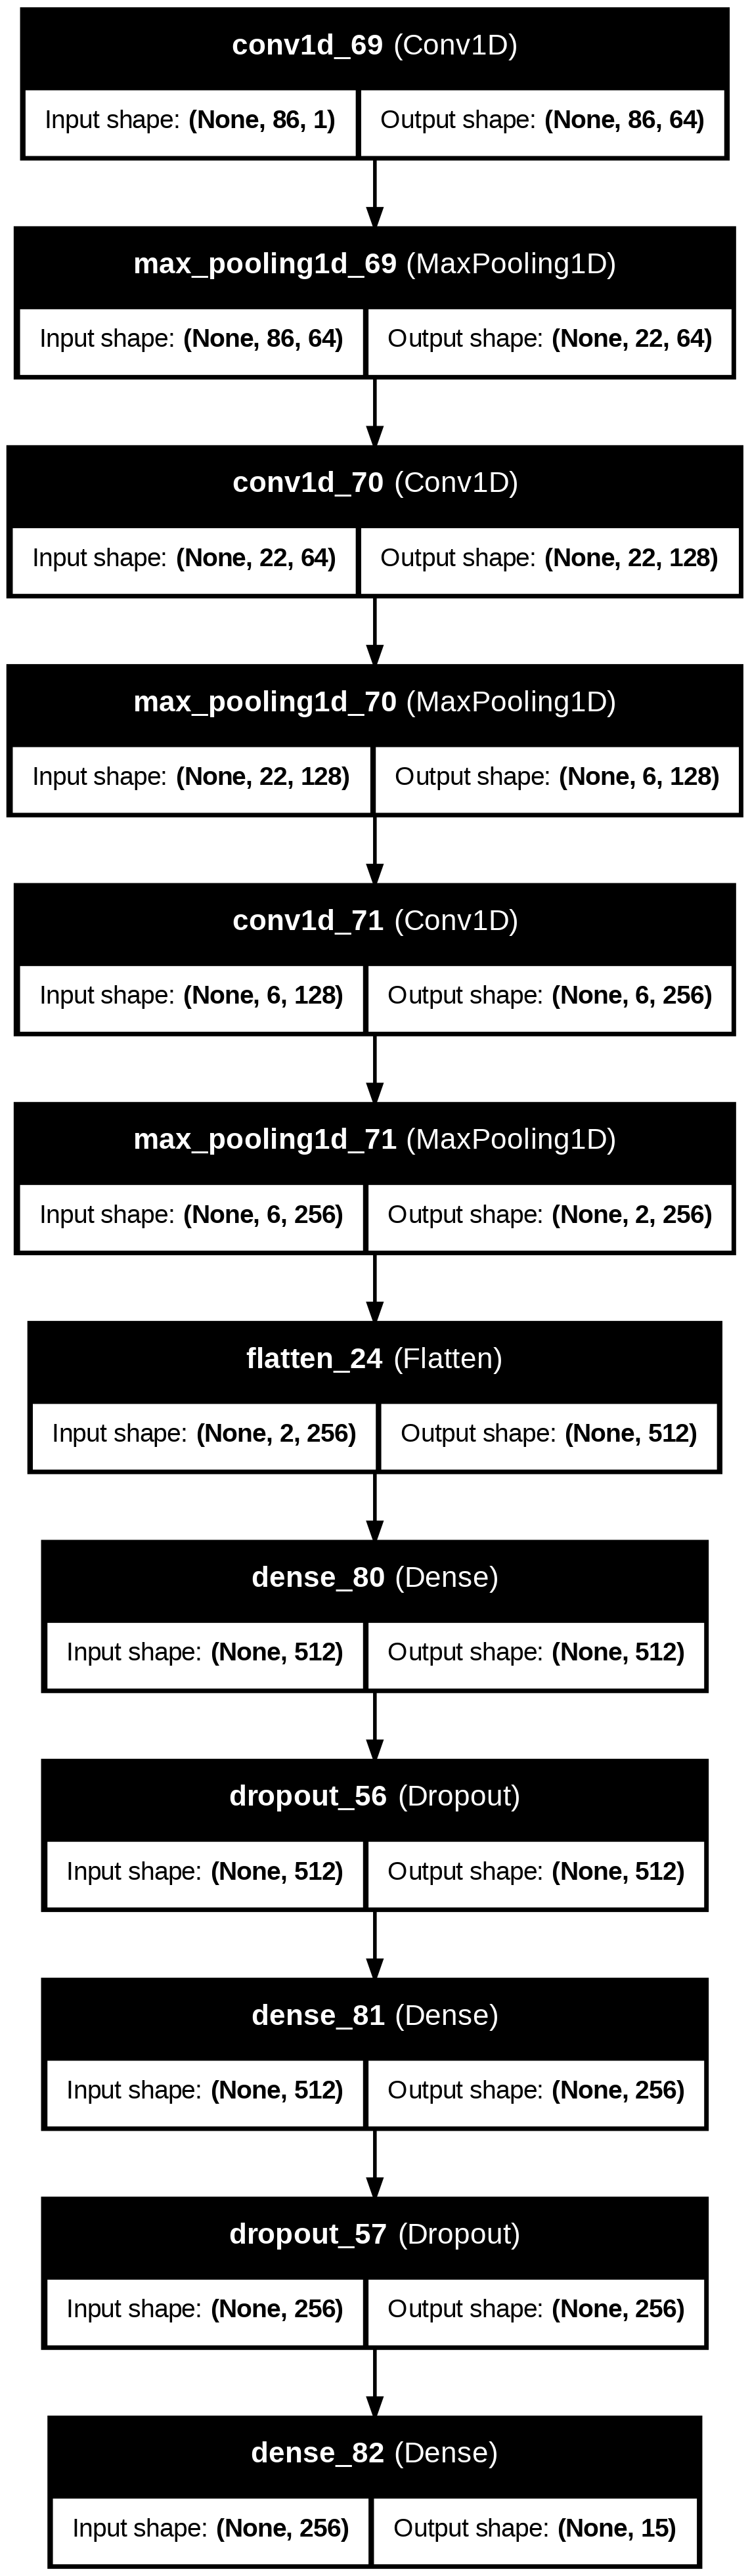

In [17]:
# Vẽ kiến trúc mô hình
plot_model(best_model, to_file='cnn_pso_model.png', show_shapes=True, show_layer_names=True)

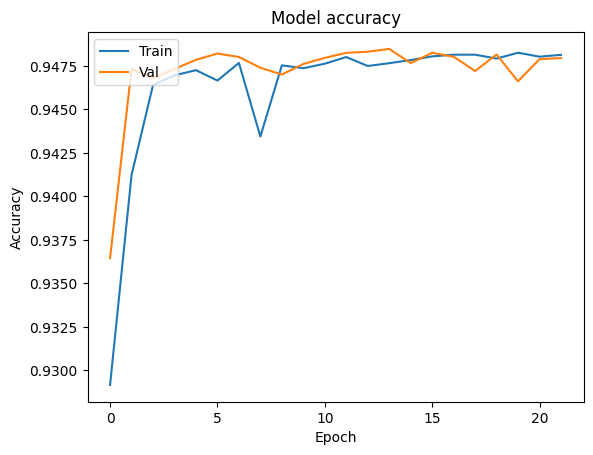

<Figure size 640x480 with 0 Axes>

In [18]:
# Vẽ biểu đồ độ chính xác huấn luyện và xác thực
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('acc_plot.png')

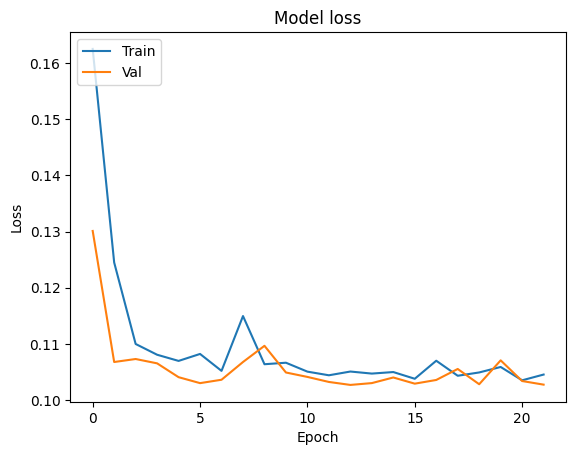

<Figure size 640x480 with 0 Axes>

In [19]:
# Vẽ biểu đồ mất mát huấn luyện và xác thực
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('los_plot.png')

In [20]:
# Đánh giá mô hình trên tập huấn luyện
train_metrics = best_model.evaluate(X_train, y_train, verbose=1)

42036/42036 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.9487 - f1: 0.8061 - loss: 0.1021 - precision: 0.9812 - recall: 0.9249


In [21]:
# Đánh giá mô hình trên tập xác thực
val_metrics = best_model.evaluate(X_val, y_val, verbose=1)

6006/6006 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9474 - f1: 0.8019 - loss: 0.1046 - precision: 0.9807 - recall: 0.9232


In [22]:
# Đánh giá mô hình trên tập kiểm tra
start_time = time.time()
print("Model performance on test dataset:")
test_metrics = best_model.evaluate(X_test, y_test, verbose=1)
end_time = time.time()
test_time = end_time - start_time
print(f"Testing time: {test_time:.2f} giây")

Model performance on test dataset:
12011/12011 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9492 - f1: 0.8074 - loss: 0.1018 - precision: 0.9813 - recall: 0.9250
Testing time: 27.89 giây


In [23]:
# Dự đoán trên tập kiểm tra
start_time = time.time()
y_pred = best_model.predict(X_test)
total_inference_time = time.time() - start_time
print(f"\nTổng thời gian dự đoán cho tập kiểm tra: {total_inference_time:.4f} giây")

12011/12011 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step

Tổng thời gian dự đoán cho tập kiểm tra: 23.0745 giây


In [24]:
# Tính thời gian suy luận trung bình cho mỗi mẫu
num_samples = X_test.shape[0]
avg_inference_time = (total_inference_time / num_samples) * 1000  # chuyển đổi sang mili giây
print(f"\nThời gian suy luận trung bình trên mỗi mẫu: {avg_inference_time:.6f} ms")


Thời gian suy luận trung bình trên mỗi mẫu: 0.060038 ms


In [25]:
# Báo cáo phân loại
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4805
           1       0.76      0.92      0.83      9709
           2       1.00      0.99      1.00     13588
           3       0.81      1.00      0.89     10013
           4       1.00      1.00      1.00     24314
           5       0.79      0.84      0.82      1706
           6       1.00      1.00      1.00       712
           7       1.00      1.00      1.00    272800
           8       0.92      0.18      0.29      9987
           9       1.00      0.50      0.66      3995
          10       1.00      0.88      0.94      2156
          11       0.92      0.19      0.31     10165
          12       1.00      0.28      0.44      7361
          13       1.00      0.84      0.91     10005
          14       0.57      0.38      0.46      3013

   micro avg       0.98      0.92      0.95    384329
   macro avg       0.92      0.73      0.77    384329
weighted avg       0.98   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


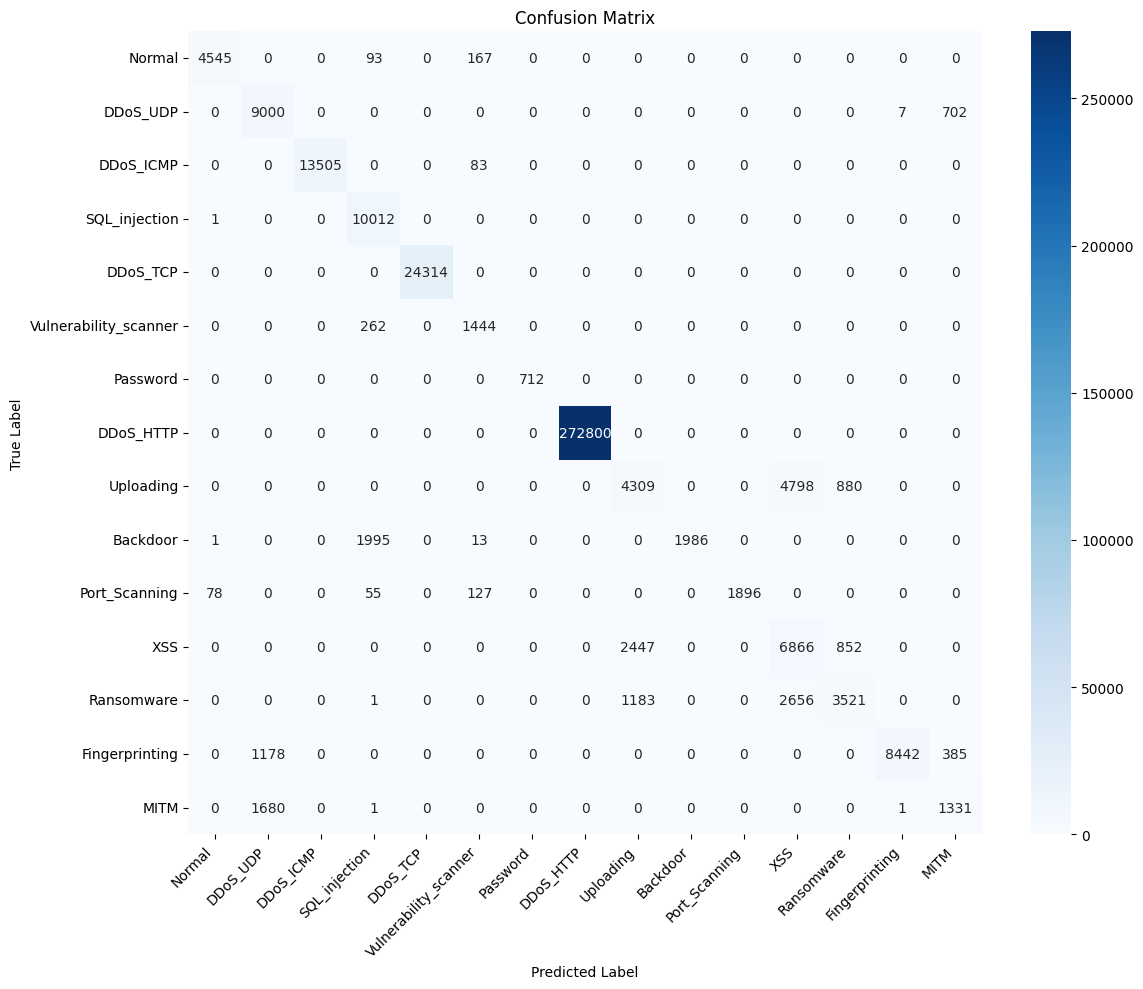

In [26]:
# Ma trận nhầm lẫn
# Lấy nhãn các lớp
class_labels = [
    'Normal', 'DDoS_UDP', 'DDoS_ICMP', 'SQL_injection', 'DDoS_TCP', 
    'Vulnerability_scanner', 'Password', 'DDoS_HTTP', 'Uploading', 
    'Backdoor', 'Port_Scanning', 'XSS', 'Ransomware', 
    'Fingerprinting', 'MITM'
]

# Chuyển đổi dự đoán sang nhãn lớp
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tạo ma trận nhầm lẫn
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))  # Điều chỉnh kích thước để hiển thị rõ
sns.heatmap(
    conf_mat, 
    annot=True,  # Hiển thị số lượng 
    fmt='d',     # Định dạng số nguyên
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix.png')
plt.show()

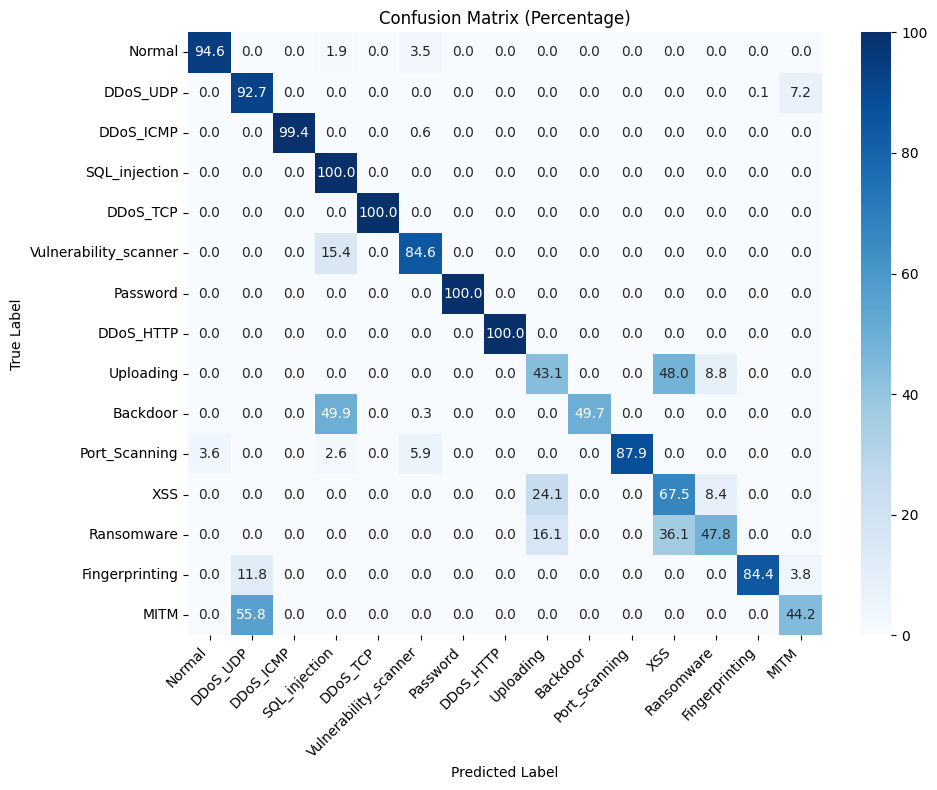

In [27]:
# Ma trận nhầm lẫn với tỷ lệ phần trăm
# Chuyển đổi sang tỷ lệ phần trăm
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))  # Tăng kích thước để hiển thị rõ
sns.heatmap(
    conf_mat_percent, 
    annot=True,  # Hiển thị số liệu 
    fmt='.1f',   # Định dạng 1 chữ số thập phân
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix_percentage.png')
plt.show()

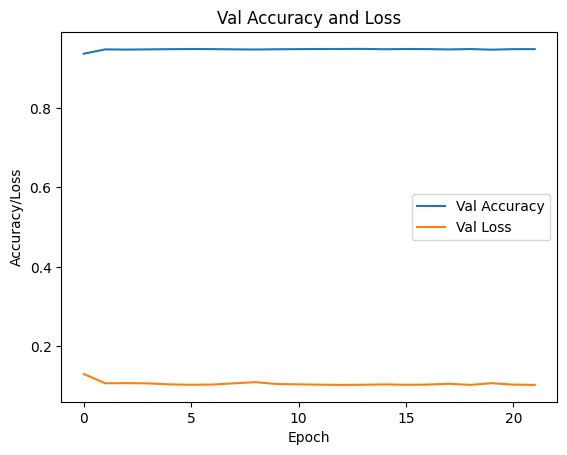

<Figure size 640x480 with 0 Axes>

In [28]:
# Độ chính xác và mất mát trên tập kiểm tra qua các epoch
test_acc = best_model_history['val_accuracy']
test_loss = best_model_history['val_loss']
plt.plot(test_acc, label='Val Accuracy')
plt.plot(test_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Val Accuracy and Loss')
plt.legend()
plt.show()
plt.savefig('val_acc_los.png')